In [8]:
# Install dependencies
!pip install numpy tqdm matplotlib geotiff rasterio georasters GDAL basemap opencv-python netCDF4
!pip install import_ipynb

In [9]:
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import rasterio as rs
import rasterio.features
import rasterio.plot
import import_ipynb
import aux_functions as auxf

# Introduction 

## Basic Concepts: InSAR, noise and all that

While we wish it would be possible to give a detailed account of what Synthetic Aperture Radars are in general, we have neither the time, nor the knowledge, nor the technical expertise to survive such an endeavour. We can, however, try to do the next best thing and get operational with it: An Interferometric Synthetic Aperture Radar is a Synthetic Aperture Radar that uses interferometry to make measurements, that is, it compares the phases of different measurements to get the information it wants.


The data that comes out, however, is extremely noisy because of a very large list of factors: A big part of it is just due to extremely small defects that make electromagnetic waves deflect differently, another one is due to tropospheric noise, that is, phase distortions due to water-vapor in the troposphere, and other scattering processes play a non-trivial role on it all.

Our job here is to separate the wheat from the chaff, and try to get from our noisy map a glimpse into the territorry. To do that, we first need actually load in our data (and know what that is!), and that in itself is a non-trivial challenge.

## Loading in the Data
Before talking about loading our data, we need to download it. We used modified an external script by the Alaska Satellite Facility that can be found in [download](download-greece.py). After the download, we're faced with a ```[filename].nc```. That file has all the information we possibly want, we just need to extract it. To do that, we've implemented a function in our [read_nc](aux_functions.ipynb#read_nc) that will take our file as an input and output all the things we can possibly want from it. Here, we'll use it to get what we want for most of our run here:

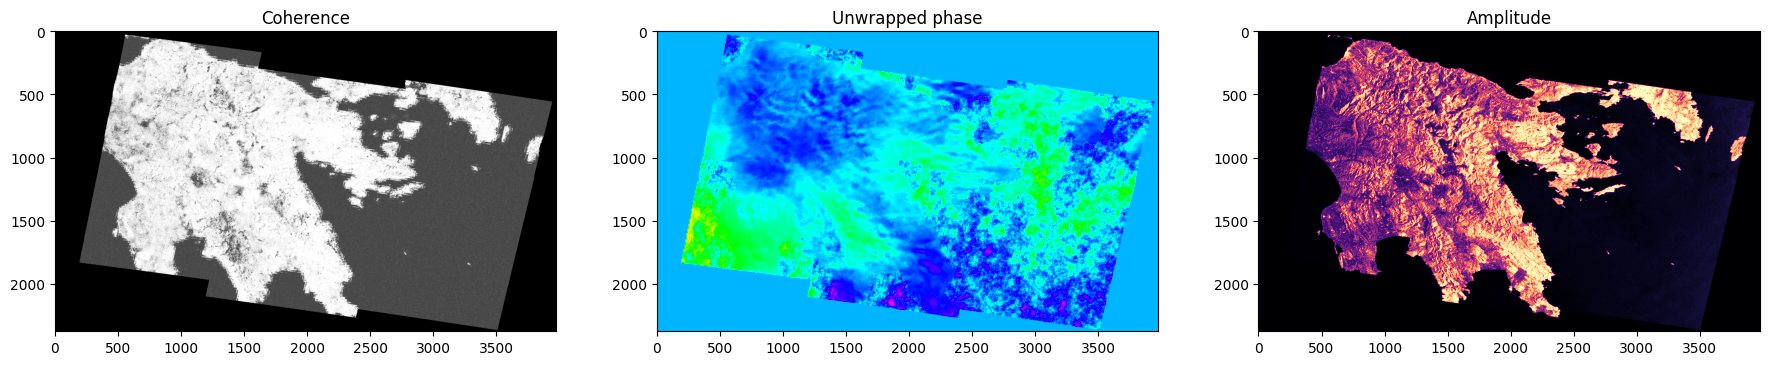

In [10]:
_, unwrapped_phase_mat, coherence_mat, amplitude_mat, _, _ = auxf.read_nc("S1-GUNW-D-R-007-tops-20220602_20220521-043224-00021E_00036N-PP-6cd4-v2_0_5.nc")
norm_uwrapped_phase_mat = auxf.normalize(unwrapped_phase_mat)

amplitude_mat = np.clip(amplitude_mat, 0, np.percentile(amplitude_mat, 90))

fig, axs = plt.subplots(1, 3, figsize=(22,22))

axs[0].imshow(coherence_mat, cmap="gray")
axs[0].set_title("Coherence")
axs[1].imshow(unwrapped_phase_mat, cmap="hsv")
axs[1].set_title("Unwrapped phase")
axs[2].imshow(amplitude_mat, cmap="magma")
axs[2].set_title("Amplitude");


As we can see, we extracted (and plot) three important pieces of information: The 'unwrapped phase', the 'coherence' . To make a long story short, coherence tells us about how 'coherent' the data is. It ranges from 0 to 1, 0 corresponding to a totally incoherent measurement and 1 corresponding to a totally coherent one. Without getting too technical, this roughly maps to how reliable our measurements are at any given point. Notice how, for example, it is essentially 0 in water, which makes sense: The ocean itself has _a lot_ of noise, and we should expect basically gibberish from it.  

This naturally leads us to our measurements, phase, which  roughly maps to how much a given point is moving, and the amplitude, which more roughly maps to a topographic map.

Thus, before we go on, we need to do an 'initial cleaning' of our data: We need to, in some way, ignore very incoherent points and focus our attention on our coherent ones. One way to do it is to simply have a 'coherence threshold', that is, to disconsider all points less coherent than a given value: 

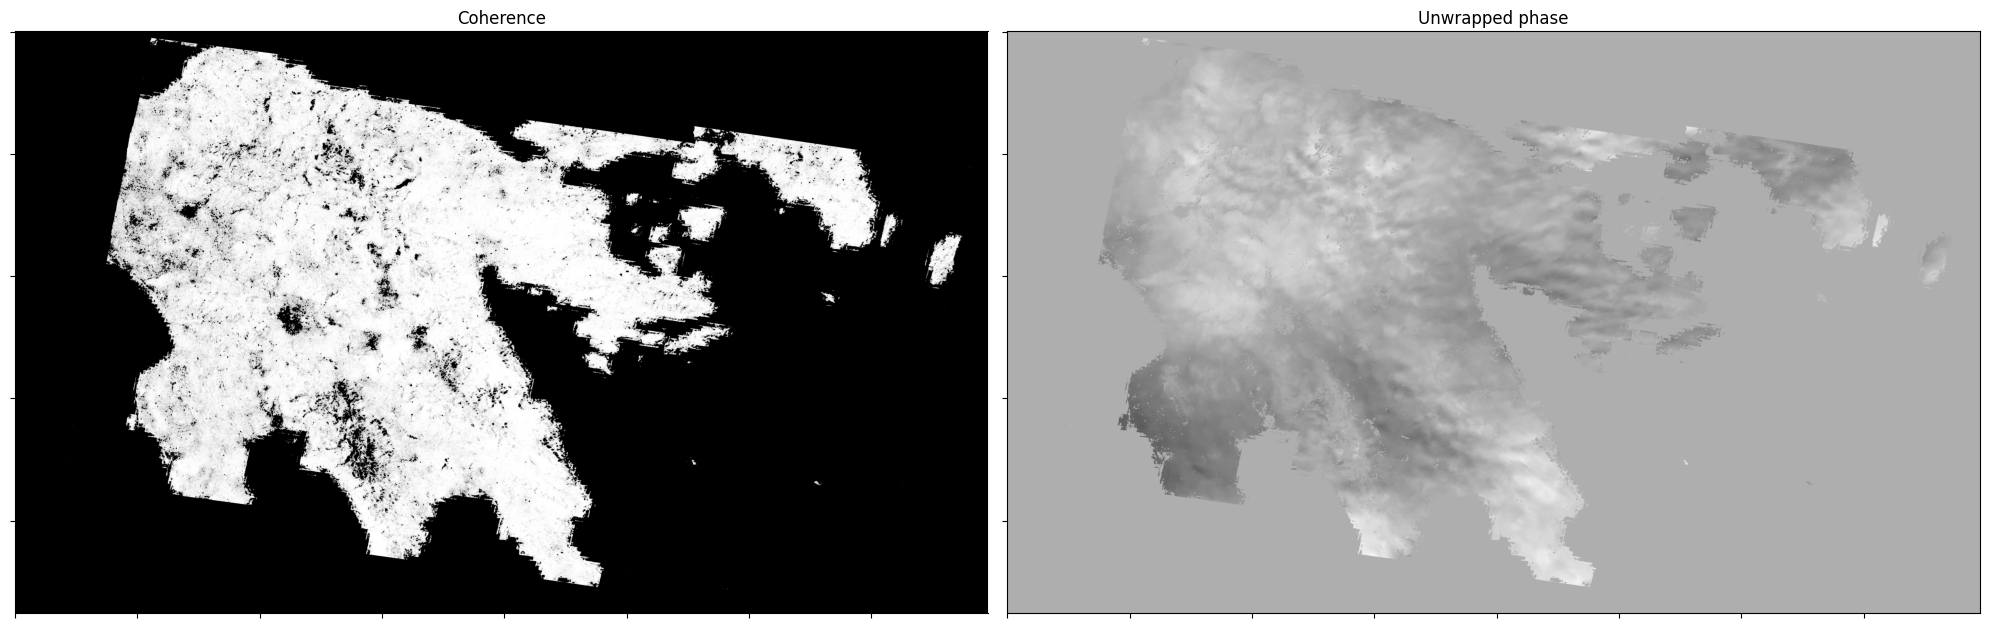

In [11]:
COHERENCE_THRESHOLD = 0.60
t_uwphase_mat = unwrapped_phase_mat * (coherence_mat > COHERENCE_THRESHOLD)
t_coherence_mat = coherence_mat * (coherence_mat > COHERENCE_THRESHOLD)

m_uwphase_mat = unwrapped_phase_mat * coherence_mat
m_coherence_mat = coherence_mat * coherence_mat

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(t_coherence_mat, cmap="gray")
axs[0].set_title("Coherence")
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

axs[1].imshow(t_uwphase_mat, cmap="gray")
axs[1].set_title("Unwrapped phase");
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

fig.tight_layout()

A more sophisticated way to achieve the same result is to do what is to do some averaging, weighted by the coherence. To do this, we use a convolution function with the normalized phase. While this seems a bit esoteric, with the parameters we will use, this corresponds to doing some weighted averaging.

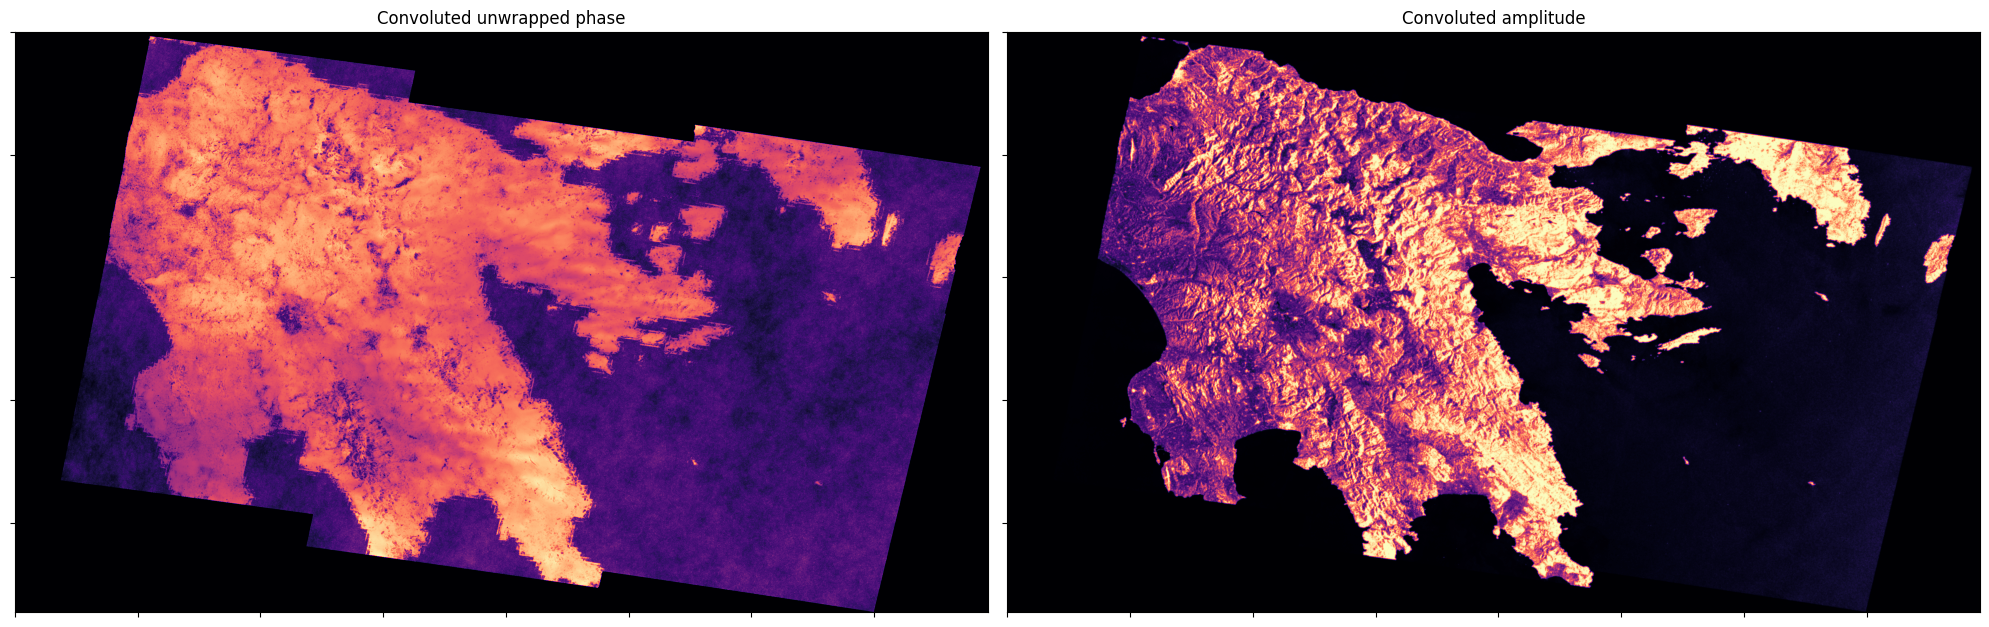

In [12]:
averaged_uwphase = auxf.convolution_in_exp_steroids(np.multiply(norm_uwrapped_phase_mat,coherence_mat),15,10)
averaged_amplitude = auxf.convolution_in_exp_steroids(amplitude_mat, 15, 1)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(averaged_uwphase, cmap="magma")
axs[0].set_title("Convoluted unwrapped phase")
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

axs[1].imshow(averaged_amplitude, cmap="magma")
axs[1].set_title("Convoluted amplitude");
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

fig.tight_layout()

This process of '[coherentizing](coherentise)' our signal is trivially implemented as a function, and that is the very first thing we must do before anything else. Now, it's time to treat our (coherent) signals. Thus, we get our coherent amplitudes and phases:

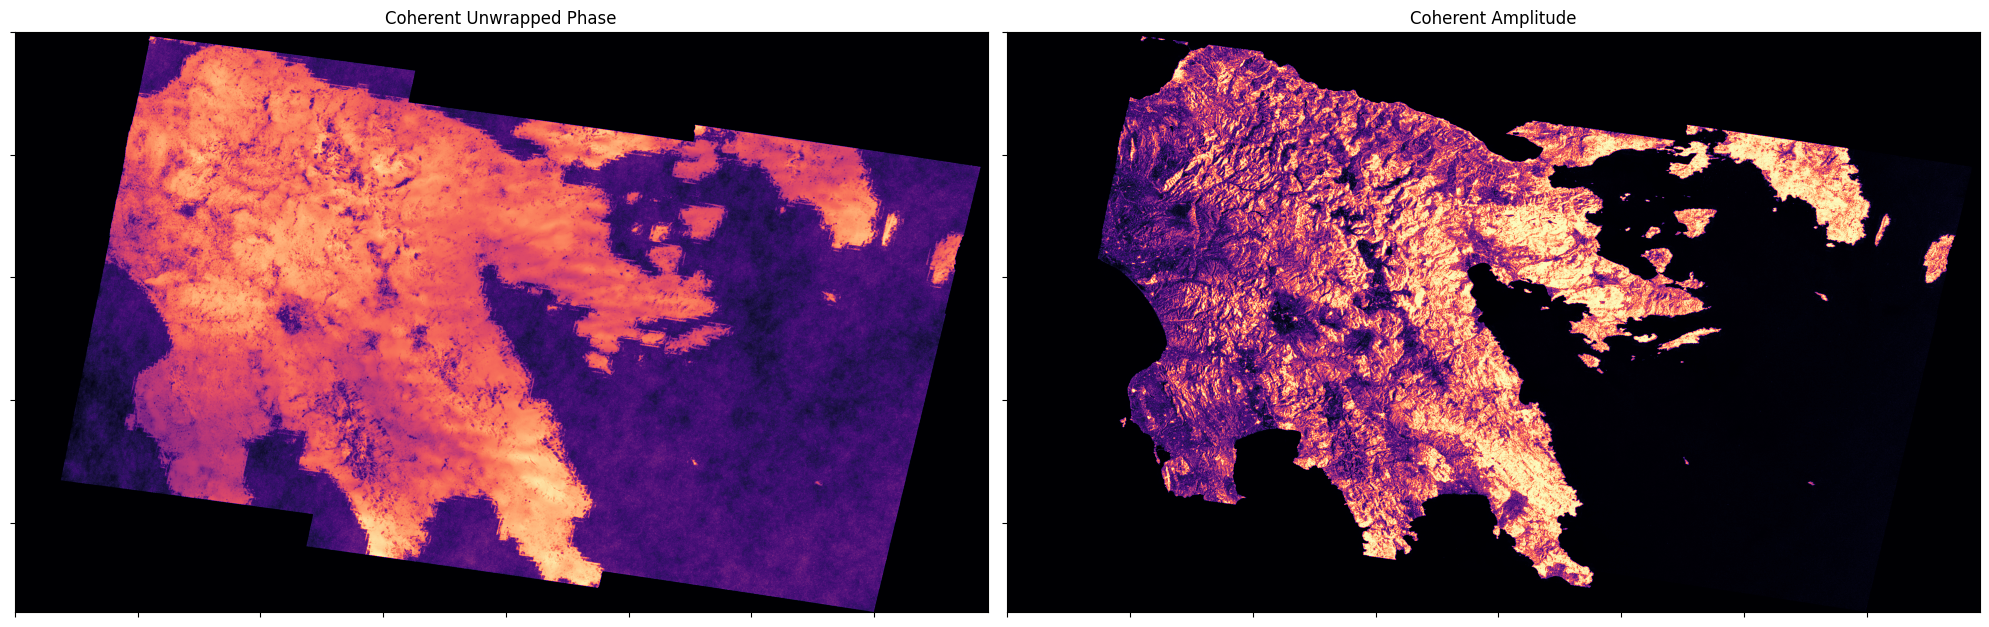

In [13]:

fig, axs = plt.subplots(1,2, figsize=(20,20))

axs[0].imshow(auxf.coherentise(unwrapped_phase_mat,coherence_mat), cmap='magma')
axs[0].set_title("Coherent Unwrapped Phase")
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

axs[1].imshow(auxf.coherentise(amplitude_mat,coherence_mat), cmap='magma')
axs[1].set_title("Coherent Amplitude")
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

fig.tight_layout()

## Spatial Filtering
Now, we get to the start of our project. Incredible! The basic premise of this section is that _extremely_ abrupt changes are _probably_ noise, both on the phase and the amplitude. There are a lot of ways to deal with this, but they're all fundamentally averaging: Noise should, on average, disappear when we do averages. Thus, every method is about how to weight our averages in a way to make sense.

The simplest implementation of this is to weight all points equally and say that every point is the total average of every other point. This has the slight problem of turning every image into _one_ solid color, that is, we lose almost all of the resolution (and information) of our sample.

This isn't ideal, so we have to think of something at least slightly better. If a _global_ average loses all information, why don't we try a _local_ average? Now, instead of weighting every point equally, we only weight (equally) all points closer than some distance $a$ and disconsider (have 0 weight) to all points outside of it.

This leads us right into our general algorithm: Convolutions. They are a mathematically (and computationally) neat way to implement this idea of doing averaging while able to mantain the generality of choosing our weights as we want (maybe we explicitly don't want to weight all points equally!)

### Convolutions, in general

Mathematically, the operation of convolution is of great interest to mathematicians, statisticians, physicists and all of their related fields because it plays extremely nicely with integration. For us, however, it is nice because it is an extremely convenient way of generalizing the process of averaging given that we will want to test different averaging functions that amounts to computing a lot of sums of multiplications.

For the  discrete case, the convolutions of two (decently well-behaved) one-dimensional series on a finite interval is:

$$(f*g)[n]=\sum\limits_{m = -M}^M f[m]g[n-m]$$

For our case, we'll be working with two-dimensional functions. In general, our $f[i,j]$ is going to be our data, i.e. a two-dimensional array of values, usually of phases, and our $g[i,j]$ is going to be our _kernel_, that is, our weights.

We have implemented a [general convolution function](ConvKer) that can be used with any kernel, and below that some with specific kernels.
### Averaging, or a uniform kernel
As discussed before, this is equivalent to defining a kernel, save for normalization, as something of the form:

$$g[n] = 1, n>n_0 \quad = 0, n<n_0$$

### Frost's filter, or negative expontentials
This method uses a negative exponential as the kernel, that is, the weight decreases exponentially with distance from the point. It is also implemented.



An animation showing how the value of B alters the smoothing in the final image.   

<img src="./anims/b_with_graph.gif"></img>

## Intereference, or how the sands of time corrode everything
We finally get to the main aim of the project: Time evolution. We want to be able to teell how our images evolve over time. This is the big reason why we can't use any time-filtering methods: We want to dected fast changes on our topography. We can't really do that by naively comparing amplitudes, and the next best thing will be to compare their phases.

This is essentially doing the differences of phase differences, and usually called Differential INSAR. To visualize our data, we will superimpose phases and amplitudes, and get something like this:

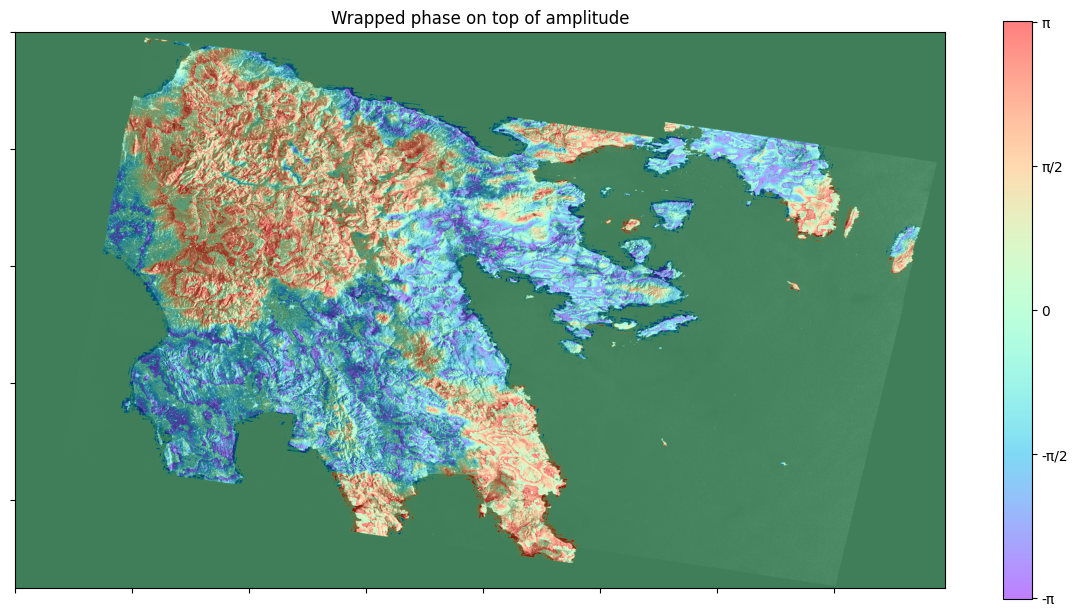

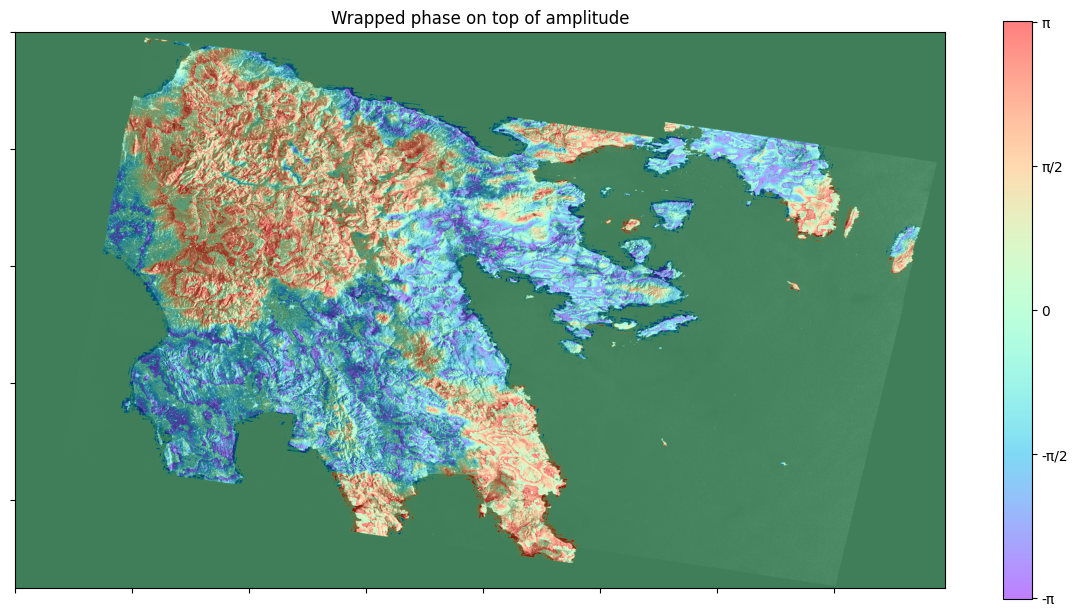

In [14]:
auxf.draw_phase_amplitude(t_uwphase_mat,amplitude_mat)

While this is not an example of graphing the phase-differences, this is the same way we will represent them. A large phase essentially means a lot of movement. Let's now analyze a concrete example of phase-differences, taken from the Ridge-Crest earthquake.

# Bibliography
* Data from [Alaska Satellite Facility](https://search.asf.alaska.edu/#/?dataset=SENTINEL-1%20INTERFEROGRAM%20(BETA))
* Algorithms and information in the subject from [ESA](https://earth.esa.int/documents/10174/2700124/sar_land_apps_1_theory.pdf)